# Riddler Classic

This problem asks how many games of War you expect to play before you encounter a game that is finished in exactly 26 turns/draws. In other words, it asks: if you split the deck randomly, what are the odds that the first 26 matches will all be a win (i.e. a higher card value and not a tie) for the same person.

Below, I first present an analytic solution to the problem. We'll find that the solution is $$\left[2\left(\frac{8}{17}\right)^{26}\right]^{-1}\approx162\,\mathrm{million}.$$

In the analytic solution, I find the probability that a given hand is a winning hand. Since the probability of every hand winning is the same (as proven in the foonote), I then find the probability that all 26 hands are won by the same person. Then, we'll use this latter probability to find the expected number of games required before a perfect game occurs.

After the analytic derivation, I implement the scenario as a Monte Carlo problem, and show that the result is consistent with the analytic prediction.


## Analytic solution

Let's look at the first draw. If each player draws a card from the deck, what is the probability that one of them will win (i.e. that it's not a tie)? There are $52*51$ ways to draw two cards from the deck (one for each player). For a given card value (i.e. suit), there are $4*3$ ways to pair them, so there are $4*3*13$ total possible ways to tie. That means the probability of not tying is $$\frac{52*51-4*3*13}{52*51}=\frac{16}{17}\approx0.9412.$$ In other words, there is 94.12\% chance of a win on the first hand.

Since the order of play doesn't matter---each individual matchup is independent---then the probability of not tying each turn stays the same as above${}^1$, and the probability that _the same person_ wins each time will be _half_ the not-tying probability, or $\frac{8}{17}\approx0.4706$. Then, we're effectively done. The probability of the same person winning 26 hands will be the probability the first match wasn't a tie, and then the probability of the same person winning the next 25 hands (or, equivalently, the probability that a given person wins 26 hands, multiplied by 2 because either person can win). So, the probability of a perfect game occurring will be $$p=\left(\frac{8}{17}\right)^{26}*2\approx0.4706^{26} * 2\approx6.17\times10^{-9},$$ or a bit better than 1 in a billion.

Generally, if you play a game of war with $n$ hands (and $n\leq26$), the probability that one person wins all hands outright is $$\left(\frac{8}{17}\right)^n * 2.$$

The [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution) describes how may trials you need before an event of probability $p$ occurs for the first time, which is the question being asked. Its mean is $1/p$, meaning on average you would expect to play about 162 million games before someone wins every match on the first run-through of their cards.

Assuming (quite generously) that shuffling, splitting, and then playing 26 draws takes 30 seconds each time, and that you never sleep or eat again, you would expect to be playing War for the next 154 years before this happened.

${}^1$ <font size=1>Let's say you're not convinced by this argument. I'll show that the full solution for the 2nd (ordered) draw is the same. By induction, it will hold for all draws after.
    
Let's call the probability of tying or not tying on the nth draw $P(T, n)$ and $P(\bar{T}, n)$, respectively. We have $$P(\bar{T}, 2) = P(\bar{T}, 2|\bar{T}, 1)\,P(\bar{T}, 1) + P(\bar{T}, 2|T, 1)\,P(T, 1),$$ where we have split it into the conditional probabilities depending on whether you tied the first hand or not. The difference in calculating these has to do with the number of ways that you can tie left at your disposal: if you didn't tie the first time, you have remaining 11 sets of 4 matching cards and 2 sets of 3 matching cards, while if you did tie the first time you have 12 sets of 4 matching cards and 1 set of 2 matching cards. This is equivalent to
$$\left(\frac{50*49-(4*3*11 + 3*2*2)}{50*49}\right)\left(\frac{52*51 - (4*3*13)}{52*51}\right) + \left(\frac{50*49-(4*3*12 + 1*1*2)}{50*49}\right)\left(1-\frac{52*51 - (4*3*13)}{52*51}\right).$$
    
Recall that the probability of not tying on the first draw is $$\frac{52*51-4*3*13}{52*51}.$$ It can be shown (e.g., with [wolframalpha](http://wolframalpha.com/), if you are short on time) that both expressions simplify to $\frac{16}{17}$. </font>

## Computational solution

Below, I implement a computational solution. I have coded it to be general, so you can make your deck size anything you want (but still assuming 4 cards of any given card type), and you can ask the question for games of any number of draws.

As asked, you would use 13 card types and 26 cards per hand.

For comparison purposes, below I'm coding up the analytic solution derived above.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def prob_win(draws, card_types=13):
    """The probability of the same person winning all draws immediately
    
    draws : the number of draws to play
    card_types (default 13) : the number of unique card values in the deck
    """
    deck_size = card_types * 4
    # draw * 2 cards have already been played
    num_combos = (deck_size) * (deck_size - 1)
    
    # number of non-tie combos
    # there are 4 * 3 * card_types total ways to tie with a fresh deck
    # on the nth draw, you have removed draw * 2 cards
    winning_combos = num_combos - 4 * 3 * card_types
    
    p = winning_combos / num_combos
    
    return (p/2)**draws * 2

In [3]:
def num_to_win(draws, card_types=13):
    """The expected number of games needed to win on all draws immediately
    
    draws : the number of draws to play
    card_types (default 13) : the number of unique card values in the deck
    """
    
    return 1 / prob_win(draws, card_types)

Below are functions for the Monte Carlo implementation, which draw cards and then see if either player wins as described above.

In [4]:
def draw_cards(cards_per_hand=None, card_types=13):
    """Divide the deck for a game of War
    
    cards_per_hand (default None): if not None, the number of hands to play
       if None, will play through the full deck (e.g., 26 hands for a 52-card deck)
    card_types (default 13) : the number of unique card values in the deck
    """
    
    deck = np.repeat(np.arange(card_types), 4)
    if cards_per_hand is None:
        cards_per_hand = len(deck) // 2
    assert cards_per_hand <= card_types * 4 / 2
    np.random.shuffle(deck)
    
    return deck[:cards_per_hand], deck[cards_per_hand:cards_per_hand+cards_per_hand]

In [5]:
def game_in_n(draws=26, card_types=13):
    """Will a game be won immediately by one person with no ties?
    
    Returns True if yes, False otherwise
    
    draws (default 26): the number of draws to play
    card_types (default 13) : the number of unique card values in the deck
    """
    deck1, deck2 = draw_cards(draws, card_types)
    if (deck1 > deck2).all() or (deck2 > deck1).all():
        return True
    else:
        return False

The Monte Carlo is pretty slow as implemented, so I show consistency with the theoretical solution up to games of 12 cards.

In [6]:
max_n = 12
time_to_success = np.zeros((max_n, 1000))
for n in range(1, max_n + 1):
    for j in range(len(time_to_success[0])):
        i = 0
        while(True):
            i += 1
            if game_in_n(n):
                break
        time_to_success[n - 1, j] = i

The plot below shows the results of the Monte Carlo experiment - the black solid line is the mean number of games played until achieving a perfect game, while the dashed lines show the 16th and 84th percentiles. The red solid line shows the analytic prediction.

Text(0, 0.5, 'Games Played Until Perfect Game')

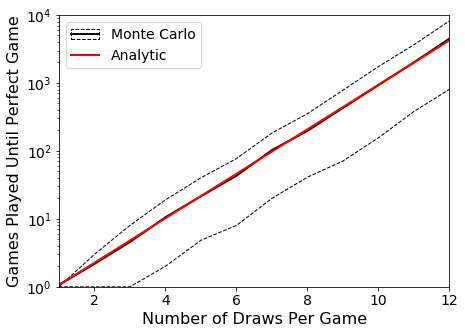

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fill = ax.fill_between(np.arange(1, max_n + 1), 
                 np.percentile(time_to_success, 16, axis=1), 
                 np.percentile(time_to_success, 84, axis=1),
                facecolor='none', edgecolor='black', ls='--')
line1, = ax.plot(np.arange(1, max_n + 1), np.mean(time_to_success, axis=1), color='black', 
        lw=2, label='Monte Carlo')
line2, = ax.plot(np.arange(1, max_n + 1), num_to_win(np.arange(1, max_n + 1)), color='red', 
        lw=2, label='Analytic')
ax.set_yscale('log')
ax.legend(handles=[(line1, fill), line2],
          labels=['Monte Carlo', 'Analytic'], fontsize=14)
ax.set_xlim(1, 12)
ax.set_ylim(1, 1e4)
ax.tick_params(labelsize=14)
ax.set_xlabel('Number of Draws Per Game', fontsize=16)
ax.set_ylabel('Games Played Until Perfect Game', fontsize=16)